# 0. Setup Code

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


## 1. Getting Data

In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 4356 (delta 154), reused 120 (delta 120), pack-reused 4171 (from 3)
Receiving objects: 100% (4356/4356), 654.37 MiB | 33.26 MiB/s, done.
Resolving deltas: 100% (2584/2584), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [5]:
#.Set training and test paths
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

## 2. Model deployment experiment outline

__3 Questions__
1. What is most ideal machine learning model deployment scenario?
2. Where is my model going to go?
3. How is my model going to function?

** For our use case **:
1. Performance should be 95%+ accuracy
2. It should be fast, close to real time (30FPS or 30ms Latency)

## 3. Creating a EffNetB2 feature extraactor

Feature Extractor: its a term of transfer learning model that has its base layers frozen and o/p layer(Layer heads) customized to a certain problem.

We'll use EffNetB2; a pretrained model on pytorch platform: https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.EfficientNet_B2_Weights

In [6]:
import torchvision
from torchvision import models

#.Setup EffnetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

#.Get EffnetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

#.Setup pretrained model instance
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights) # can use "DEFAULT" for weights

#.Freeze all base layers
for param in effnetb2.parameters():
  param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 107MB/s]


In [7]:
import torchinfo
torchinfo.summary(effnetb2, input_size=(1, 3, 224, 224),
                  col_names=['input_size','output_size','num_params','trainable'],
                  col_width=20,
                  row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   False
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16,

In [8]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [9]:
set_seeds()
#.Change classifier head
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1408, out_features=3, bias=True)
).to(device)

In [10]:
torchinfo.summary(effnetb2, input_size=(1, 3, 224, 224),
                  col_names=['input_size','output_size','num_params','trainable'],
                  col_width=20,
                  row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 3.1 Creating a funnction to make a EffnetB2 feature extractor

In [11]:
def create_effnetb2_model(num_classes = 3,
                         seed = 42):
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights = weights)
  for param in model.parameters():
    param.requires_grad = False
  set_seeds(seed)
  model.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=num_classes)
  )
  return model, transforms


In [12]:
effnetb2, effnetb2_transforms = create_effnetb2_model()
effnetb2

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## 3.2 Creating DataLoaders for EffNetB2

In [13]:
from going_modular.going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names_effnetb2 = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = effnetb2_transforms,
    batch_size = 32)

In [14]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names_effnetb2

(15, 5, ['pizza', 'steak', 'sushi'])

## 3.3 Training the EffnetB2 feature extractor model

In [15]:
from going_modular.going_modular import engine
#.loss_function
loss_fn = torch.nn.CrossEntropyLoss()
#.optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=0.001)
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                epochs=10,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9839 | train_acc: 0.5667 | test_loss: 0.7393 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7135 | train_acc: 0.8396 | test_loss: 0.5862 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5874 | train_acc: 0.8958 | test_loss: 0.4891 | test_acc: 0.9563
Epoch: 4 | train_loss: 0.4488 | train_acc: 0.9146 | test_loss: 0.4338 | test_acc: 0.9409
Epoch: 5 | train_loss: 0.4277 | train_acc: 0.9125 | test_loss: 0.3907 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4392 | train_acc: 0.8896 | test_loss: 0.3525 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4246 | train_acc: 0.8771 | test_loss: 0.3263 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3885 | train_acc: 0.8979 | test_loss: 0.3465 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3795 | train_acc: 0.8812 | test_loss: 0.3127 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3752 | train_acc: 0.8688 | test_loss: 0.2811 | test_acc: 0.9625


### 3.4 Inspect the EffnetB2 loss curves

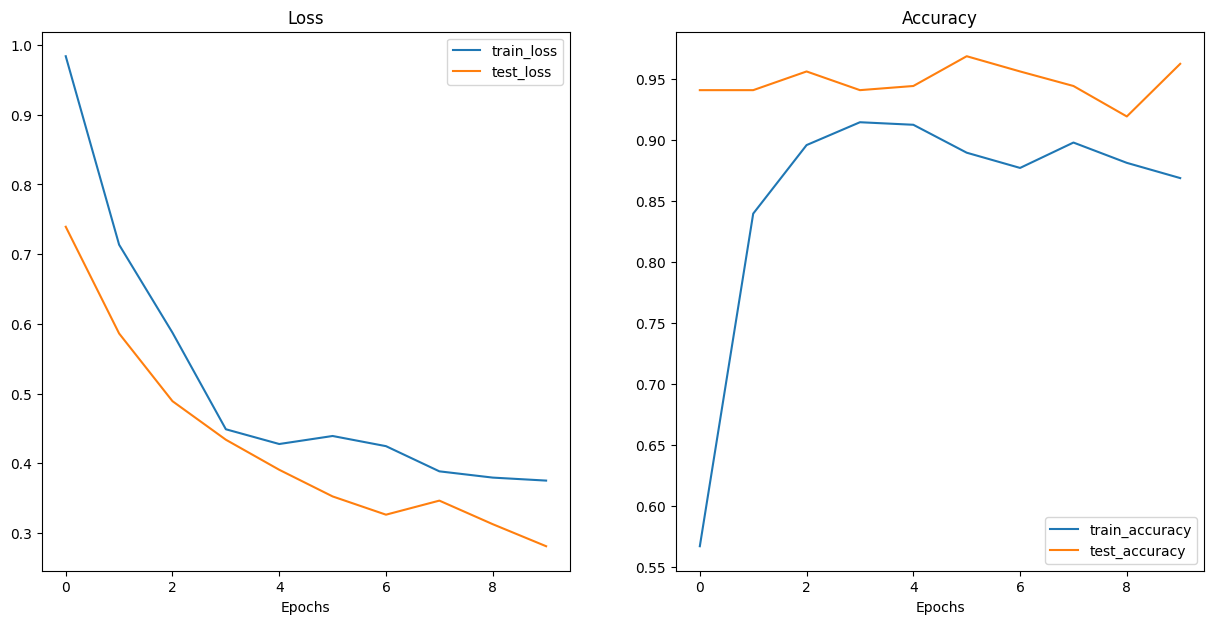

In [16]:
from helper_functions import plot_loss_curves
plot_loss_curves(effnetb2_results)

## 3.5 Saving EffnetB2 to a file

In [17]:
# from going_modular.going_modular import utils
# utils.save_model(model=effnetb2,
#                  target_dir="models",
#                  model_name="EffNetB2_20p.pth")

[INFO] Saving model to: models/EffNetB2_20p.pth


In [18]:
from pathlib import Path

pretrained_effnetb2_size = Path("models/EffNetB2_20p.pth").stat().st_size
pretrained_effnetb2_size_mb=pretrained_effnetb2_size/(1024*1024)

### 3.7 Collecting the Models stats

In [19]:
# Count number of params in EffNetB2
effnetb2_total_params = sum(p.numel() for p in effnetb2.parameters())
effnetb2_total_params

7705221

In [20]:
#.get a dict of models stat(train function return the stats dicton per epoch base) we're taking only last epoch value
effnetb2_stats={
    "train_loss": effnetb2_results["train_loss"][-1],
    "train_acc": effnetb2_results["train_acc"][-1],
    "test_loss": effnetb2_results["test_loss"][-1],
    "test_acc": effnetb2_results["test_acc"][-1],
    'number_of_params': effnetb2_total_params,
    'model_size': pretrained_effnetb2_size_mb
}
effnetb2_stats

{'train_loss': 0.3752264002958933,
 'train_acc': 0.86875,
 'test_loss': 0.28108686208724976,
 'test_acc': 0.9625,
 'number_of_params': 7705221,
 'model_size': 29.82744789123535}

# Creating ViT model with same setup as Effnetb2

In [21]:
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [22]:
def create_vit_model(num_classes=3,
                     seed=42):
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  #.Freeze base layer
  for param in model.parameters():
    param.requires_grad = False

  #.Change classifier
  set_seeds(seed)
  model.heads = nn.Sequential(
      nn.Linear(in_features=768, out_features=num_classes)
  )
  return model, transforms

In [23]:
vit, vit_transforms = create_vit_model()
vit_transforms

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 176MB/s]


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [24]:
torchinfo.summary(vit, input_size=(1, 3, 224, 224),
                  col_names=['input_size','output_size','num_params','trainable'],
                  col_width=20,
                  row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

## 4.1 Create DataLoaders for ViT extractor

In [25]:
#.Setup ViT DataLoader
from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size = 32)

### 4.2 Training VIt feature extractor

In [26]:
from going_modular.going_modular import engine

#.Setup loss
loss_fn = torch.nn.CrossEntropyLoss()
#.Setup optimizer
optimizer = torch.optim.Adam(params = vit.parameters(),lr=0.001)

vit_results = engine.train(model=vit,
                          train_dataloader=train_dataloader_vit,
                          test_dataloader=test_dataloader_vit,
                          optimizer=optimizer,
                          loss_fn=loss_fn,
                          epochs=10,
                          device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6173 | train_acc: 0.7854 | test_loss: 0.2692 | test_acc: 0.9352
Epoch: 2 | train_loss: 0.2241 | train_acc: 0.9437 | test_loss: 0.1414 | test_acc: 0.9631
Epoch: 3 | train_loss: 0.1539 | train_acc: 0.9563 | test_loss: 0.1071 | test_acc: 0.9722
Epoch: 4 | train_loss: 0.1412 | train_acc: 0.9625 | test_loss: 0.0966 | test_acc: 0.9693
Epoch: 5 | train_loss: 0.1058 | train_acc: 0.9667 | test_loss: 0.0866 | test_acc: 0.9722
Epoch: 6 | train_loss: 0.0903 | train_acc: 0.9729 | test_loss: 0.0823 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0783 | train_acc: 0.9792 | test_loss: 0.0772 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0693 | train_acc: 0.9792 | test_loss: 0.0712 | test_acc: 0.9784
Epoch: 9 | train_loss: 0.0615 | train_acc: 0.9896 | test_loss: 0.0705 | test_acc: 0.9722
Epoch: 10 | train_loss: 0.0548 | train_acc: 0.9938 | test_loss: 0.0667 | test_acc: 0.9722


### 4.3 PLot loss curve

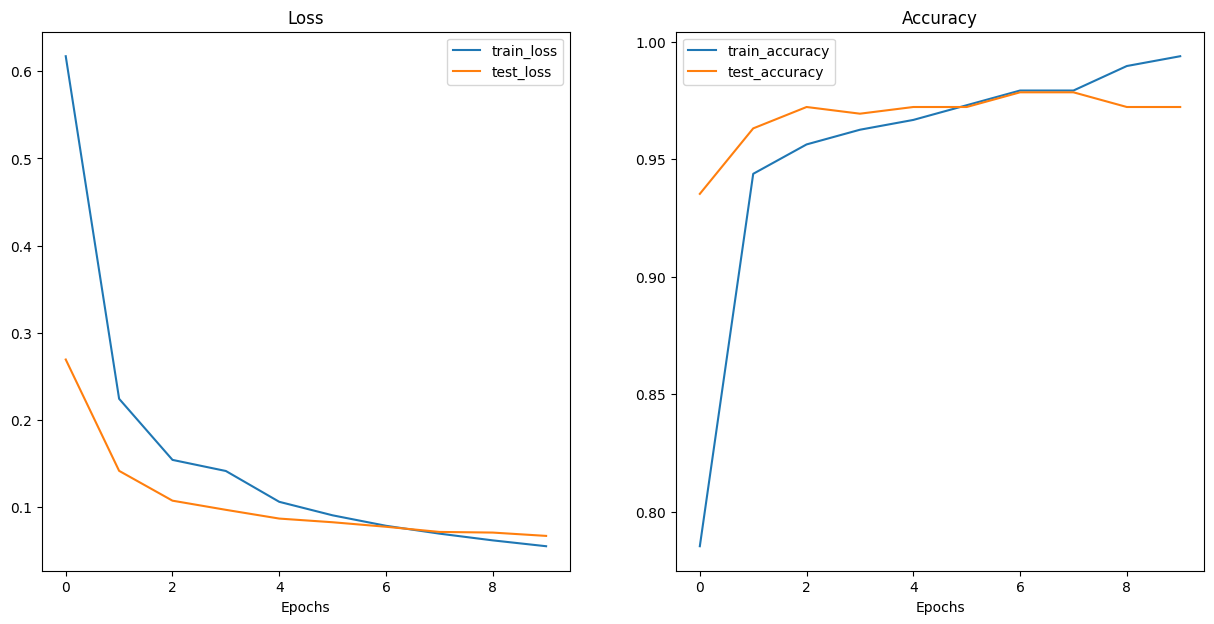

In [27]:
from helper_functions import plot_loss_curves
plot_loss_curves(vit_results)

### 4.4 Saving te ViT model

In [28]:
from going_modular.going_modular import utils
utils.save_model(model=vit,
                 target_dir="models",
                 model_name="ViT_20p.pth")

[INFO] Saving model to: models/ViT_20p.pth


In [29]:
from pathlib import Path

pretrained_vit_size = Path("models/ViT_20p.pth").stat().st_size
pretrained_vit_size_mb=pretrained_vit_size/(1024*1024)
pretrained_vit_size_mb

327.36169624328613

### 4.5 Get the ViT model stats

In [30]:
#.Count the number of params in ViT
vit_total_params = sum(p.numel() for p in vit.parameters())
vit_total_params, effnetb2_total_params

(85800963, 7705221)

In [31]:
#.Create ViT Stats dict
vit_stats = {
    "train_acc": vit_results["train_acc"][-1],
    "test_acc": vit_results["test_acc"][-1],
    "train_loss": vit_results["train_loss"][-1],
    "test_loss": vit_results["test_loss"][-1],
    'number_of_params': vit_total_params,
    'model_size': pretrained_vit_size_mb
}
vit_stats

{'train_acc': 0.99375,
 'test_acc': 0.972159090909091,
 'train_loss': 0.054822758212685584,
 'test_loss': 0.06667962307110428,
 'number_of_params': 85800963,
 'model_size': 327.36169624328613}

# 5.Making prediction on trained models and time them

Our goal:
 1. performs well(95%+ test accuracy)
 2. Fast(30+FPS)

 Testing (2)
  1. Loop through imgs
  2. time how long each model takes to make a prediction on 1 img



In [32]:
from pathlib import Path

test_data_paths = list(Path(test_dir).glob('*/*.jpg'))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1555015.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/788315.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/998005.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1687143.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2398925.jpg')]

### 5.1 Create a function to make across the test dataset

1. function will take list of paths and trained PyTorch and a series of transforms a list of traget class names and target device
2. Have empty list for collecting preds
3. Loop through target i/p paths
4. have empty dict for each sample
5. Get class label path
6. start timer
7. open img using `PIL.Image.open(pth)`
8. transform img to tensor
9. turn on eval mode and set device
10. Make a forward pass and get pred proba, class
11. add preds to dict and list
12. end timer


In [33]:
import pathlib
import torch
from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
                   )->List[Dict]:
                   #2.Create an empty prediction list
                   pred_list = []

                   #3.Loop through target i/p paths
                   for path in tqdm(paths):
                     pred_dict = {}
                     #4.Get Sample path and ground truth class from filepath
                     pred_dict["image_path"] = path
                     class_name = path.parent.stem
                     pred_dict["class_name"] = class_name

                     #5.Start timer
                     start_time = timer()

                     #6.Open image url
                     img = Image.open(path)

                     #7.Transform the img to model compatible form
                     transformed_img = transform(img).unsqueeze(0).to(device)

                     #8.Turn on model evaluation mode and send img to target device
                     model = model.to(device)
                     model.eval()

                     #9.Turn on inference mode
                     with torch.inference_mode():
                       #10.Make a forward pass
                       pred_logits = model(transformed_img)
                       pred_prob = torch.softmax(pred_logits,dim=1)
                       pred_label = torch.argmax(pred_prob,dim=1)
                       pred_class = class_names[pred_label.cpu()]

                     #11.Add pred_prob+pred_class to dict
                     pred_dict['pred_prob'] = round(pred_prob.unsqueeze(0).max().cpu().item(),4)
                     pred_dict['pred_class'] = pred_class

                     #12.End timer
                     end_time = timer()
                     pred_dict['time_for_pred'] = round(end_time-start_time,4)

                     #13. Match the true positive values
                     pred_dict['correct'] = class_name==pred_class
                     #14. Append the dict to list
                     pred_list.append(pred_dict)
                   return pred_list


### 5.2 Making preds on EffNetB2



In [34]:
effnetb2_test_pred_dicts = pred_and_store(paths = test_data_paths,
                                          model = effnetb2,
                                          transform = effnetb2_transforms,
                                          class_names=class_names)


  0%|          | 0/150 [00:00<?, ?it/s]

In [35]:
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1555015.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9558,
  'pred_class': 'pizza',
  'time_for_pred': 0.0966,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/788315.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.7435,
  'pred_class': 'pizza',
  'time_for_pred': 0.0353,
  'correct': True}]

In [36]:
#.Turn test_pred_dict into data frame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.9558,pizza,0.0966,True
1,data/pizza_steak_sushi_20_percent/test/pizza/7...,pizza,0.7435,pizza,0.0353,True
2,data/pizza_steak_sushi_20_percent/test/pizza/9...,pizza,0.5599,pizza,0.0270,True
3,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.9211,pizza,0.0238,True
4,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.8828,pizza,0.0250,True


In [37]:
effnetb2_test_pred_df.correct.value_counts()

,count
correct,
True,144
False,6


In [38]:
effnetb2_avg_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(),4)
effnetb2_avg_time_per_pred

0.0275

### 5.3 Make time preds with ViT

In [39]:
vit_test_pred_dicts = pred_and_store(paths = test_data_paths,
                                          model = vit,
                                          transform = vit_transforms,
                                          class_names=class_names)


  0%|          | 0/150 [00:00<?, ?it/s]

In [40]:
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1555015.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9987,
  'pred_class': 'pizza',
  'time_for_pred': 0.0391,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/788315.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9982,
  'pred_class': 'pizza',
  'time_for_pred': 0.0338,
  'correct': True}]

In [41]:
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.9987,pizza,0.0391,True
1,data/pizza_steak_sushi_20_percent/test/pizza/7...,pizza,0.9982,pizza,0.0338,True
2,data/pizza_steak_sushi_20_percent/test/pizza/9...,pizza,0.9986,pizza,0.0339,True
3,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.9989,pizza,0.0365,True
4,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.9985,pizza,0.0346,True


In [42]:
vit_test_pred_df.correct.value_counts()

,count
correct,
True,146
False,4


# 6. Comparing the model results and prediction times and size

In [43]:
df = pd.DataFrame([effnetb2_stats,vit_stats])
df['model']= ['EffNetB2', 'ViT']
df['test_acc'] = round(df.test_acc*100,2)
df.head()

,train_loss,train_acc,test_loss,test_acc,number_of_params,model_size,model
0,0.375226,0.86875,0.281087,96.25,7705221,29.827448,EffNetB2
1,0.054823,0.99375,0.066680,97.22,85800963,327.361696,ViT


__How to decide which model is better?__

* `test_loss`: lower=better -> ViT
* `test_acc`: higher=better -> ViT
* `num_params`: less param = less computation -> EffNetB2
* `Model_size`: disk space -> EffNetB2
* `time_per_pred_cpu`: lower=better(though h/w dependant) -> EffNetB2

but both have on execution time > 30FPS




In [44]:
#.Ratio comparision (difference between both models aspects in %)
pd.DataFrame(data=(df.set_index('model').loc['ViT']/df.set_index('model').loc['EffNetB2']),columns=['Vit/EffNetB2']).T

,train_loss,train_acc,test_loss,test_acc,number_of_params,model_size
Vit/EffNetB2,0.146106,1.143885,0.237221,1.010078,11.135432,10.975183


## 7.Deploying app to real world using __Gradio__

We'll deploy the EffNetB2 as it full fills the criteria best.

What's Gradio?<br>
=>https://www.gradio.app/

In [45]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 110.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.2 MB/s eta 0:00:00
Gradio version: 5.9.1


### 7.1 Gradio overview
Gradio helps you to create machine learning demos.

Why create a demo?

So other people can try our models and we can test them in the real-world.
<br>
The overall premise of gradio is to map i/p->functions/model->o/p

### 7.2 Create a gradio function to map i/o

In [46]:
#.Put model into CPU
effnetb2.to('cpu') #.gradion free tier has only cpu device

#.Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

In [47]:
from typing import Tuple, Dict
def predict(img):
  #.Start timer
  start_time = timer()
  #.Transforms i/p img for use with effnetb2
  img = effnetb2_transforms(img).unsqueeze(0)
  #.Put model in eval mode and make preds
  effnetb2.eval()
  with torch.inference_mode():
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  #.Create pred_label, pred_proba dict
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  #.Calc pred time
  pred_time = round(timer()-start_time,4)

  #.Return pred dict and time
  return pred_labels_and_probs, pred_time

In [48]:
import random
from PIL import Image

test_data_paths = list(Path(test_dir).glob('*/*.jpg'))
random_path=random.choice(test_data_paths)
img = Image.open(random_path)

print(f'Pred on:{random_path}')
pred_dict, pred_time = predict(img)
pred_dict, pred_time

Pred on:data/pizza_steak_sushi_20_percent/test/sushi/301603.jpg


({'pizza': 0.050496555864810944,
  'steak': 0.07812225818634033,
  'sushi': 0.8713811635971069},
 0.2438)

### 7.3 Creating a list of examples

The example of gradio can be create with the `examples` parameter. you can find it on docs

In [49]:
#.Example list for gradio
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, 3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/steak/476333.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/sushi/1994748.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/40947.jpg']]

### 7.4 Building gradio interface

lets use `gr.interface()`

In [50]:
import gradio as gr

#.Create title
title = 'Food-vision 🍕🥩🍣'
description = 'An EffNetB2 feature extracting CV model to classify food in the image(pizza,steak or sushi)'
article = 'Created in google colab.'

#.Create gradio demo
demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type='pil'),
                    outputs = [gr.Label(num_top_classes = len(class_names), label='predictions '),
                               gr.Number(label='Prediction time(s)')],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

#.Launch the demo
demo.launch(debug=False, #.print error locally
            share=True) #.generate a publically sharable url

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ed840da2d4435cbdf7.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## 8.Turning Our gradio demo into deployable app

Our gradio demos from google colab are time constrained and expire in 72hr.
Thus we need to host our app on Hugging face free spaces.

Hugging-face spaces is like github for ML demos

### 8.1 Deployed Gradio app structure
To upload our demo Gradio app, we'll want to put everything relating to it into a single directory.

For example, our demo might live at the path demos/foodvision_mini/ with the file structure:

```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```
Where:

09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth is our trained PyTorch model file.
app.py contains our Gradio app (similar to the code that launched the app).
Note: app.py is the default filename used for Hugging Face Spaces, if you deploy your app there, Spaces will by default look for a file called app.py to run. This is changeable in settings.
examples/ contains example images to use with our Gradio app.
model.py contains the model definition as well as any transforms associated with the model.
requirements.txt contains the dependencies to run our app such as torch, torchvision and gradio.
Why this way?

Because it's one of the simplest layouts we could begin with.

Our focus is: experiment, experiment, experiment!

The quicker we can run smaller experiments, the better our bigger ones will be.

We're going to work towards recreating the structure above but you can see a live demo app running on Hugging Face Spaces as well as the file structure:
Where:

09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth is our trained PyTorch model file.
app.py contains our Gradio app (similar to the code that launched the app).
Note: app.py is the default filename used for Hugging Face Spaces, if you deploy your app there, Spaces will by default look for a file called app.py to run. This is changeable in settings.
examples/ contains example images to use with our Gradio app.
model.py contains the model definition as well as any transforms associated with the model.
requirements.txt contains the dependencies to run our app such as torch, torchvision and gradio.
Why this way?

Because it's one of the simplest layouts we could begin with.

Our focus is: experiment, experiment, experiment!

The quicker we can run smaller experiments, the better our bigger ones will be.

We're going to work towards recreating the structure above but you can see a live demo app running on Hugging Face Spaces as well as the file structure:


### 8.2 Creating demos folder to store the app

In [51]:
import shutil
from pathlib import Path

#.Create apps demo path
food_vision_demo_path = Path('demos/food_vision')
#.Remove exsisting and crete new
if food_vision_demo_path.exists():
  shutil.rmtree(food_vision_demo_path)
  food_vision_demo_path.mkdir(parents=True, exist_ok=True)
else:
  food_vision_demo_path.mkdir(parents=True, exist_ok=True)

!ls demos/food_vision/

### 8.3 Create a folder of example images

In [52]:
import shutil
from pathlib import Path

#.Create examples path
food_vision_example_path = food_vision_demo_path/'examples'
food_vision_example_path.mkdir(parents=True, exist_ok=True)

#.Collect 3 random dataset for test
food_vision_example=[Path('data/pizza_steak_sushi_20_percent/test/sushi/804460.jpg'),
 Path('data/pizza_steak_sushi_20_percent/test/steak/746921.jpg'),
 Path('data/pizza_steak_sushi_20_percent/test/steak/2117351.jpg')]

#.Copy 3 imgs to above dir
for example in food_vision_example:
  destination = food_vision_example_path/example.name
  print(f'Copying {example} to {destination}')
  shutil.copy2(src=example, dst=destination)

Copying data/pizza_steak_sushi_20_percent/test/sushi/804460.jpg to demos/food_vision/examples/804460.jpg
Copying data/pizza_steak_sushi_20_percent/test/steak/746921.jpg to demos/food_vision/examples/746921.jpg
Copying data/pizza_steak_sushi_20_percent/test/steak/2117351.jpg to demos/food_vision/examples/2117351.jpg


In [53]:
#.Get the path in [[path],..] format for gradio
import os
#.Get example filepath in list of lists
example_list=[['examples/'+example] for example in os.listdir(food_vision_example_path)]
example_list

[['examples/746921.jpg'], ['examples/2117351.jpg'], ['examples/804460.jpg']]

### 8.4 Moving our trained Effnetb2 model to our demo dir


In [54]:
import shutil

#.Crete src path for target model
effnetb2_model_path = 'models/EffNetB2_20p.pth'
#.Create dest path
effnetb2_model_path_dest = food_vision_demo_path / effnetb2_model_path.split('/')[1]
#.Copy model
try:
  print(f'Attempting to move {effnetb2_model_path} to {effnetb2_model_path_dest}')
  shutil.move(src=effnetb2_model_path, dst=effnetb2_model_path_dest)
  print(f'Operation completed')
except:
  print(f'Unable to move. Already exists')
  print(f'Model present at: {effnetb2_model_path_dest}: {os.path.exists(effnetb2_model_path_dest)}')

Attempting to move models/EffNetB2_20p.pth to demos/food_vision/EffNetB2_20p.pth
Operation completed


### 8.5 Turning the effnetb2 model in pyScript a model.py file

In [55]:
%%writefile demos/food_vision/model.py
import torch
import torchvision

from torch import nn

def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Writing demos/food_vision/model.py


In [56]:
from demos.food_vision import model
import torchvision
effnetb2_model, effnetb2_transforms = model.create_effnetb2_model()
effnetb2_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### 8.6 Turning our Gradio app into python script(app.py)

1. Import class names setup
2. Model and transform preparations
3. predict function(predict())
4. Gradio app - our gradio interface + launch command

In [57]:
%%writefile demos/food_vision/app.py

### 1. Imports and classnames setup
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import defaut_timer as timer
from typing import Tuple, Dict

#.Setup class names
class_names = ['pizza', 'steak', 'sushi']

### 2.Model and transforms preparations
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=len(class_names))

#.Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f='models/EffNetB2_20p.pth',
        map_location=torch.device('cpu') #hardcoding to load on cpu
    )
  )
### 3. Predict function
def predict(img):
  #.Start timer
  start_time = timer()
  #.Transforms i/p img for use with effnetb2
  img = effnetb2_transforms(img).unsqueeze(0)
  #.Put model in eval mode and make preds
  effnetb2.eval()
  with torch.inference_mode():
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  #.Create pred_label, pred_proba dict
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  #.Calc pred time
  pred_time = round(timer()-start_time,4)

  #.Return pred dict and time
  return pred_labels_and_probs, pred_time

### 4.Gradio app
#.Create title
title = 'Food-vision 🍕🥩🍣'
description = 'An EffNetB2 feature extracting CV model to classify food in the image(pizza,steak or sushi)'
article = 'Created in google colab.'

#.create example filepath in list of lists
example_list=[['examples/'+example] for example in os.listdir('examples')]
example_list

#.Create gradio demo
demo = gr.Interface(fn=predict,
                    inputs=gr.Image(type='pil'),
                    outputs = [gr.Label(num_top_classes = len(class_names), label='predictions '),
                               gr.Number(label='Prediction time(s)')],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

#.Launch the demo
demo.launch(debug=False, #.print error locally
            share=True) #.generate a publically sharable url

Writing demos/food_vision/app.py


### 8.7 Create `requirements.txt`

The requirements file will tell our hugging face space what software dependencies our app requires

* torch
* torchvision
* gradio


In [58]:
%%writefile demos/food_vision/requirements.txt

torchvision
torch
gradio

Writing demos/food_vision/requirements.txt


# 9.Deploying our app to HuggingFace spaces

we have two way to do this that is
1. Using Web interface
2. using terminal

There is also a programatic way using huggingface_hub lib

### 9.1 Download the app files

In [59]:
!ls demos/food_vision

app.py	EffNetB2_20p.pth  examples  model.py  __pycache__  requirements.txt


In [60]:
#.create a zip of app files
!cd demos/food_vision && zip -r ../food_vision_app.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

  adding: app.py (deflated 53%)
  adding: EffNetB2_20p.pth (deflated 8%)
  adding: examples/ (stored 0%)
  adding: examples/746921.jpg (deflated 0%)
  adding: examples/2117351.jpg (deflated 1%)
  adding: examples/804460.jpg (deflated 1%)
  adding: model.py (deflated 55%)
  adding: requirements.txt (deflated 8%)


In [61]:
#.Downloading *specific to colab
try:
  from google.colab import files
  files.download('demos/food_vision_app.zip')
except:
  print('Not running on google colab, download manually')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 9.2 Uploading our app to hugging face spaces

we can follow the tutorial on hugging space. We'll need the acess_token and a free account.

In [62]:
#.Embeed the hugging face demo in our colab notebook
from IPython.display import IFrame

IFrame(src='https://abhi-c6-dev-pytorch-trainer.hf.space',width=900, height=750)

## 10.Expanding our foodvision to classify 101 categories

In [63]:
#.10.1 Creating a model for FoodV-101 + Transforms
effnetb2_101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

In [64]:
summary(effnetb2_101,input_size=(1,3,224,224),col_names=['input_size','output_size','num_params','trainable'],col_width=20, row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

*__Note:__*
* Since we're working with larger dataset, we may want to introduce some data augmentation.
* That is to mitigate the overfitting problem that comes with larger dataset.
* We'll use TrivialAugment as our data augmentation layer


In [65]:
food_101_transforms = torchvision.transforms.Compose([torchvision.transforms.TrivialAugmentWide(),effnetb2_transforms])

food_101_transforms #this is only the training transforms, we'll still use effnetb2_transform for test phase


Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

# 10.2 Get Food-101 data

In [66]:
from torchvision import datasets

from pathlib import Path

data_path = Path('data')
#.Traindata(`750x101 classes)
train_data = datasets.Food101(root=data_path,
                                    split='train',
                                    transform=food_101_transforms, #transform with augmentation
                                    download=True)

#.Testdata(`250x101 classes)
test_data = datasets.Food101(root=data_path,
                                    split='test',
                                    transform=effnetb2_transforms, #transform without augmentation
                                    download=True)

100%|██████████| 5.00G/5.00G [03:51<00:00, 21.5MB/s]


Extracting data/food-101.tar.gz to data


In [67]:
food_101_classes = train_data.classes
food_101_classes[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

We'll create a subset of above data to make the train-test faster

In [68]:
from torch.utils.data import random_split
def split_dataset(dataset:torchvision.datasets, split_size:float=0.2,seed:int=42):
  #.Create split length on og dataset
  length_1 = int(len(dataset)*split_size)
  length_2 = len(dataset) - length_1
  #.Create split dataset
  print(f'Splitting data in lenght of sizes,\n len1:{length_1}, len2:{length_2}')
  random_split_1, random_split_2 = random_split(dataset,
                                lengths=[length_1,length_2],
                                generator=torch.manual_seed(seed))
  return random_split_1, random_split_2

In [69]:
#.Creating 20% split of food 101
train_data_food101_20p,_ = split_dataset(dataset=train_data, split_size=0.2)
test_data_food101_20p,_ = split_dataset(dataset=test_data, split_size=0.2)

Splitting data in lenght of sizes,
 len1:15150, len2:60600
Splitting data in lenght of sizes,
 len1:5050, len2:20200


In [70]:
len(train_data_food101_20p), len(test_data_food101_20p)

(15150, 5050)

### 10.4 Turning imgs to data loader

In [71]:
import torch
import os

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

#.Train dataloader
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(
    dataset=train_data_food101_20p,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    # pin_memory=True
)

#.Test dataloaders
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(
    dataset=test_data_food101_20p,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    # pin_memory=True
)

In [72]:
len(train_dataloader_food101_20_percent), len(test_dataloader_food101_20_percent)

(474, 158)

### 10.5 Training FoodVision 101

Things to do:
1. 5 Epochs
2. Optimizer: `Adam`
3. Loss function: `torch.nn.CrossEntropyLoss with label smoothing`

Label Smoothing is another regularization technique for preventing overfitting, by adding noise to label


In [74]:
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params = effnetb2_101.parameters(),lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

set_seeds()
effnetb2_food101_results = engine.train(model=effnetb2_101,
                                    train_dataloader=train_dataloader_food101_20_percent,
                                    test_dataloader=test_dataloader_food101_20_percent,
                                    optimizer=optimizer,
                                    loss_fn=loss_fn,
                                    epochs=5,
                                    device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6422 | train_acc: 0.2795 | test_loss: 2.7824 | test_acc: 0.4903
Epoch: 2 | train_loss: 2.8626 | train_acc: 0.4410 | test_loss: 2.4729 | test_acc: 0.5334
Epoch: 3 | train_loss: 2.6559 | train_acc: 0.4866 | test_loss: 2.3633 | test_acc: 0.5556
Epoch: 4 | train_loss: 2.5455 | train_acc: 0.5124 | test_loss: 2.3022 | test_acc: 0.5751
Epoch: 5 | train_loss: 2.4963 | train_acc: 0.5235 | test_loss: 2.2799 | test_acc: 0.5810


### 10.6 Inspecting loss curves for Food 101

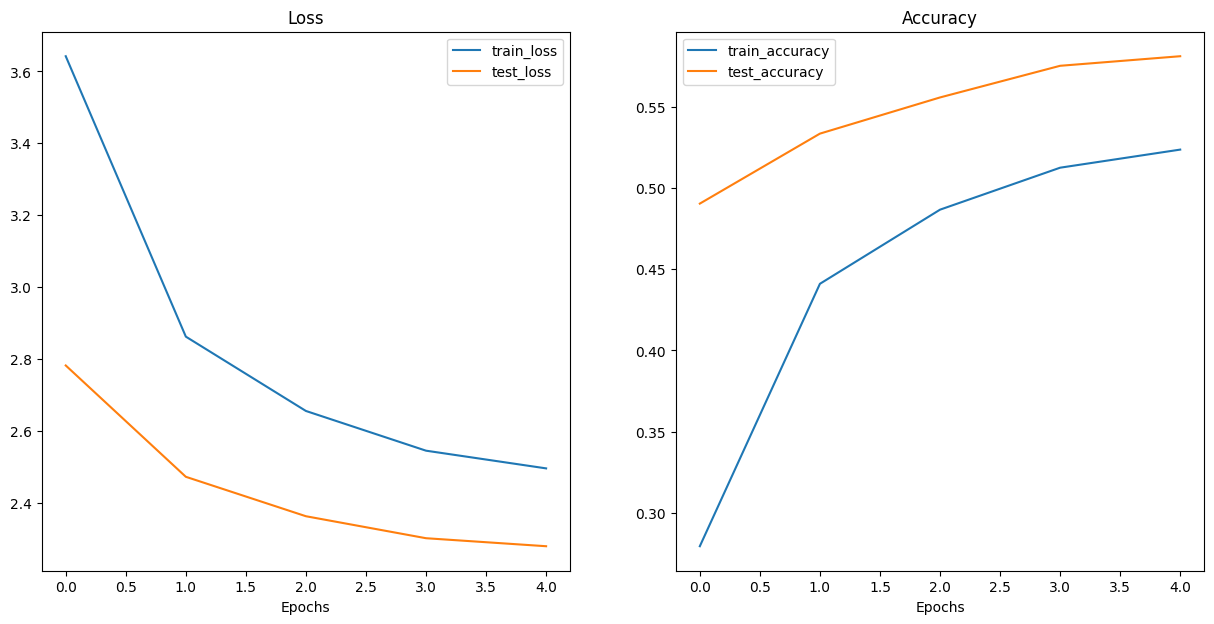

In [75]:
#.The original paper had 54% accuracy with 100%data(10yrs ago) but we have 58% with only 20% data
from helper_functions import plot_loss_curves
plot_loss_curves(effnetb2_food101_results)

### 10.7 Save and load The big model

In [91]:
from going_modular.going_modular import utils
effnetb2_food101_model_path = 'Food_Vision_101_20p.pth'

utils.save_model(model=effnetb2_101,
                 target_dir='.',
                 model_name=effnetb2_model_path)

[INFO] Saving model to: models/models/EffNetB2_20p.pth


In [81]:
#.Get size of our model

FileNotFoundError: [Errno 2] No such file or directory: 'Food_Vision_101_20p.pth'